<a href="https://colab.research.google.com/github/howcanigetyourmind/deeplearning-koreauniversty/blob/master/object_detection_TensorflowAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1
**Object Detection API configuration**: In this step, the model for object detection is downloaded, also some copying and deletion of references are done to leave the whole scheme configured.

In [2]:
!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models

Cloning into 'models'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 28921 (delta 0), reused 1 (delta 0), pack-reused 28910
Receiving objects: 100% (28921/28921), 509.63 MiB | 29.57 MiB/s, done.
Resolving deltas: 100% (17942/17942), done.
Checking out files: 100% (3048/3048), done.
Cloning into 'models'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 28921 (delta 0), reused 1 (delta 0), pack-reused 28910
Receiving objects: 100% (28921/28921), 509.63 MiB | 29.10 MiB/s, done.
Resolving deltas: 100% (17942/17942), done.
Checking out files: 100% (3048/3048), done.


# Step 2

**Imports** needed to run the Object Detection API demonstration

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Step 3
**Configuration** of the model to use, path to the frozen inference graph and extra config elements for the Object detection API implementation.

In [4]:
# What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'

# model with more accurancy but up to you use a diferent model
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2017_11_08'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
    
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

W0726 05:59:42.467439 139782909097856 deprecation_wrapper.py:119] From /content/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Step 4
Section with demo images enviroment

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

# Step 5
piece of code that represent the concrete detection, calling the TF session

In [0]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

# Custom Personal Images 

In [0]:
!mkdir images

In [20]:
!wget http://farm6.staticflickr.com/5485/9424913933_2d24e654ac_z.jpg -O images/custom_img_2.jpg 

--2019-07-26 06:06:15--  https://file2.nocutnews.co.kr/newsroom/image/2018/04/16/20180416092322866190_0_400_600.jpg
Resolving file2.nocutnews.co.kr (file2.nocutnews.co.kr)... 222.122.14.66
Connecting to file2.nocutnews.co.kr (file2.nocutnews.co.kr)|222.122.14.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36853 (36K) [image/jpeg]
Saving to: ‘20180416092322866190_0_400_600.jpg’

2018041609232286619 100%[===================>]  35.99K   192KB/s    in 0.2s    

2019-07-26 06:06:17 (192 KB/s) - ‘20180416092322866190_0_400_600.jpg’ saved [36853/36853]



In [26]:

!wget http://farm4.staticflickr.com/3674/9412766091_03a2e22443_z.jpg -O images/custom_img_1.jpg 

--2019-07-26 06:07:39--  https://file2.nocutnews.co.kr/newsroom/image/2018/04/16/20180416092322866190_0_400_600.jpg
Resolving file2.nocutnews.co.kr (file2.nocutnews.co.kr)... 222.122.14.66
Connecting to file2.nocutnews.co.kr (file2.nocutnews.co.kr)|222.122.14.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36853 (36K) [image/jpeg]
Saving to: ‘20180416092322866190_0_400_600.jpg.1’

2018041609232286619 100%[===================>]  35.99K   192KB/s    in 0.2s    

2019-07-26 06:07:40 (192 KB/s) - ‘20180416092322866190_0_400_600.jpg.1’ saved [36853/36853]



In [27]:
!ls ./images/

custom_img_1.jpg  custom_img_2.jpg


In [0]:
PATH_TO_TEST_IMAGES_DIR = 'images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'custom_img_{}.jpg'.format(i)) for i in range(1, 3) ]

IMAGE_SIZE = (12, 8)

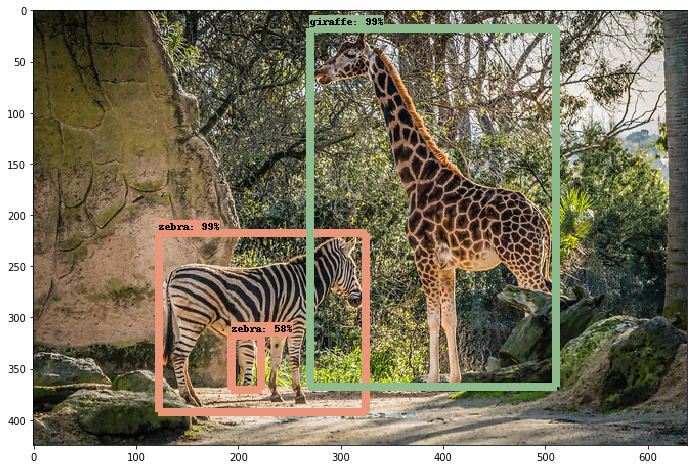

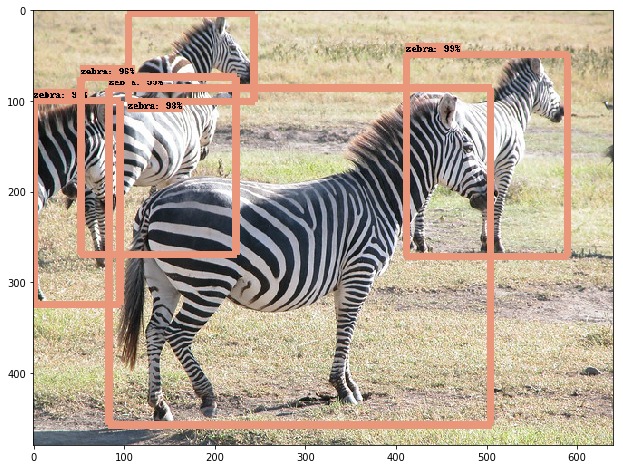

In [29]:

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

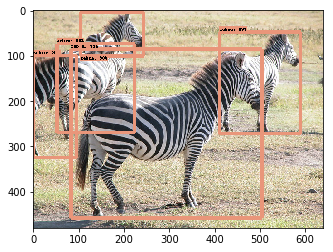

In [30]:
%matplotlib inline

plt.imsave('test.jpg',image_np)
plt.imshow(image_np)
plt.show();

